# Alberi con attributi

I nodi non sono più tipi elementari, ma mappe "attributo -> valore"

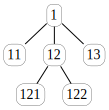

In [ ]:
from liblet import Tree

tree = [1, [11], [12, [121], [122]], [13]]

t = Tree.from_lol(tree)
t

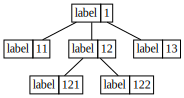

In [ ]:
def to_dct(tree):
    root, *children = tree
    return [{'label': root}] + [to_dct(st) for st in children]

Tree.from_lol(to_dct(tree))

## Attributi ereditati

Calcolati *top-down*

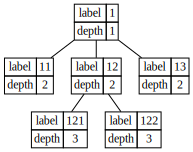

In [ ]:
def add_depth(parent, tree):
    root, *children = tree
    root['depth'] = parent['depth'] + 1
    for st in children: add_depth(root, st)

dct_tree = to_dct(tree)        
add_depth({'depth': 0}, dct_tree)        
Tree.from_lol(dct_tree)

## Attributi sintetizzati

Calcolati *bottom-up*

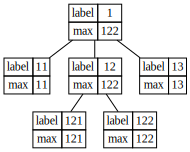

In [ ]:
def add_max(tree):
    root, *children = tree
    if not children: root['max'] = int(root['label'])
    else:
        res = []
        for st in children: 
            add_max(st)
            res.append(st[0]['max'])
        root['max'] = max(res)

dct_tree = to_dct(tree)        
add_max(dct_tree)
Tree.from_lol(dct_tree)

# EABCP

Una *EABCP* (espressione aritmetica completamente parentesizzata) è:

* un numero, oppure 
* `(` seguita da una *EABCP*, seguita da `+` o `*`, seguito da una *EABCP*, seguita da `)`.

## Tokenizzare

Usiamo l'implementazione delle espressioni regolari di Python

In [ ]:
# con le re

from re import finditer

def tokenizer(chars):
    it = iter(_.group() for _ in finditer(r'[(+*)]|\d+', chars))
    def next_token():
        return next(it, None)
    return next_token

La funzione `tokenizer` data una stringa restituisce una funzione `next_token` che, ad ogni invocazione, restituisce il successivo *token* della stringa.

In [ ]:
next_token = tokenizer('((123 +4 ) * 56) + 2)')       
while True:
    token = next_token()
    if token is None: break 
    print(f'<{token}>', end = ' ')

<(> <(> <123> <+> <4> <)> <*> <56> <)> <+> <2> <)> 

## Costruzione dell'*AST*

Costruiamo un *AST* (albero sintattico) che rappresenti la "struttura" dell'EABCP

In [ ]:
def ast_eabcp(next_token):
    token = next_token()
    if token == '(':
        left = ast_eabcp(next_token)
        op = next_token()
        right = ast_eabcp(next_token)
        closed_paren = next_token()
        return [op, left, right]
    else:
        return [int(token)]

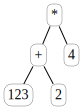

In [ ]:
tree = ast_eabcp(tokenizer(' ((123+  2 ) *4) '))
Tree.from_lol(tree)

## Valutazione dell'espressione 

Costruiamo una funzione per *valutare* l'EABCP con l'aiuto di una *dispatch table*

In [ ]:
from operator import add, mul

DISPATCH_TABLE = {
    '+': add,
    '*': mul
}

In [ ]:
def eval_eabcp(next_token):
    token = next_token()
    if token == '(':
        left = eval_eabcp(next_token)
        op = next_token()
        right = eval_eabcp(next_token)
        closed_paren = next_token()
        return DISPATCH_TABLE[op](left, right)
    else:
        return int(token)

In [ ]:
eval_eabcp(tokenizer('(2 + (3 * 4))'))

14

## Traduzione in RPN

Ora vediamo come tradurre una EABCP in una corrispondente espressione in [RPN](https://en.wikipedia.org/wiki/Reverse_Polish_notation)

In [ ]:
def rpn_eabcp(next_token):
    token = next_token()
    if token == '(':
        left = rpn_eabcp(next_token)
        op = next_token()
        right = rpn_eabcp(next_token)
        closed_paren = next_token()
        return left + right + (op, )
    else:
        return (int(token), )

In [ ]:
rpn = rpn_eabcp(tokenizer('((3 * 4) + 2)'))
rpn

(3, 4, '*', 2, '+')

### <span style="color: red;">Esercizio per casa</span>

Scrivete una funzione che, usando l'[algoritmo di valutazione postfissa](https://en.wikipedia.org/wiki/Reverse_Polish_notation#Postfix_evaluation_algorithm) valuti una EABCP dopo averla tramutata in una espressione RPN con la precedente funzione.

#### <span style='color: orange;'>Soluzione</span>

In [ ]:
from collections import deque

def eval_rpn(lst):
    rpn = deque(lst)
    next_token = rpn.popleft
    stack = deque()
    push = stack.append
    pop = stack.pop
    while rpn:
        t = next_token()
        if t in DISPATCH_TABLE:
            right = pop()
            left = pop()
            push(DISPATCH_TABLE[t](left, right))
        else:
            push(t)
    return stack[0]
        
eval_rpn(rpn)

14